В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто задча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-4" (use force=True to force download)
Area under ROC score on Train dataset: 0.8825


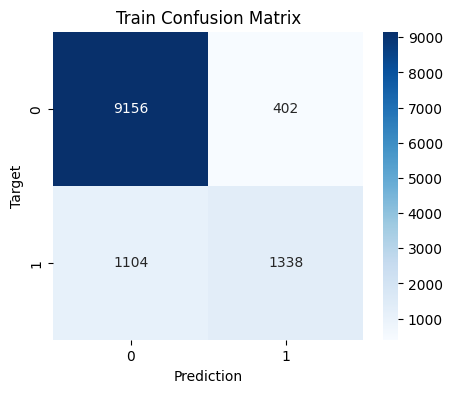

Area under ROC score on Validation dataset: 0.8797


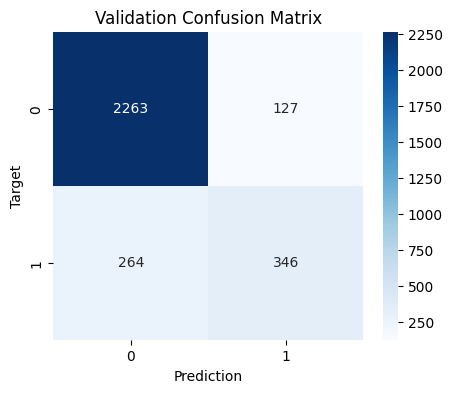

['log_reg_pipeline.joblib']

In [1]:
# FULL PIPELINE: Logistic Regression with sklearn.Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

# 0. Завантаження даних
dataset_url = "https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-4/data?select=train.csv"
od.download(dataset_url)
data_dir = 'bank-customer-churn-prediction-dlu-course-c-4'
os.listdir(data_dir)


# 1. Читання даних
raw_df = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-4/train.csv', index_col=0)

# 2. Розбиття на train / validation (20%)
train_df, val_df = train_test_split(
    raw_df,
    test_size=0.2,
    random_state=42,
    stratify=raw_df['Exited']
)

# 3. Створення train/val наборів
target_col = 'Exited'
drop_cols = ['CustomerId', 'Surname', 'id']  # неважливі колонки для моделі

input_cols = [c for c in raw_df.columns if c not in drop_cols + [target_col]]

train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# 4. Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include=['object']).columns.tolist()

# 5. Трансформери
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 6. В один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# 7. Повний пайплайн: препроцесинг + модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# 8. Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)


# 9. Функція оцінки моделі
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)[:, 1]

    roc_auc = roc_auc_score(targets, probs)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}")

    confusion_matrix_ = confusion_matrix(targets, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix_, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    return preds

# 10. Оцінюємо модель
train_preds = predict_and_plot(
    model_pipeline,
    train_inputs,
    train_targets,
    name='Train'
)

val_preds = predict_and_plot(
    model_pipeline,
    val_inputs,
    val_targets,
    name='Validation'
)

# 11. Збереження моделі
joblib.dump(model_pipeline, 'log_reg_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train Poly2 dataset: 0.9303


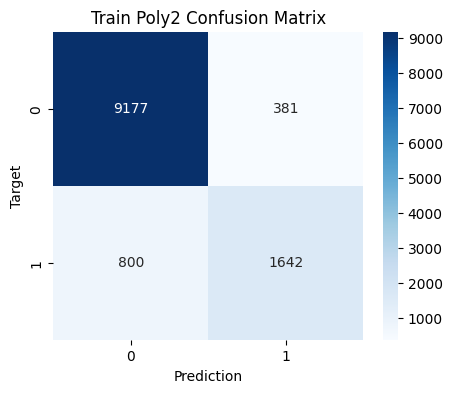

Area under ROC score on Validation Poly2 dataset: 0.9275


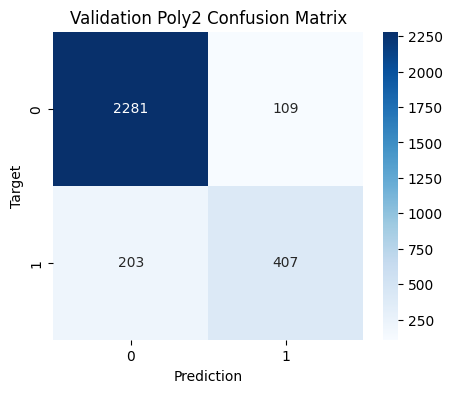

In [2]:
from sklearn.preprocessing import PolynomialFeatures

# Новий numeric transformer
numeric_transformer_poly2 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# Новий препроцесор
preprocessor_poly2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Новий пайплайн
model_pipeline_poly2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly2),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Тренування
model_pipeline_poly2.fit(train_inputs, train_targets)

# Метрики
train_preds_poly2 = predict_and_plot(
    model_pipeline_poly2,
    train_inputs,
    train_targets,
    name='Train Poly2'
)

val_preds_poly2 = predict_and_plot(
    model_pipeline_poly2,
    val_inputs,
    val_targets,
    name='Validation Poly2'
)


In [ ]:
#Я додав поліноміальні ознаки до 2 степеня і модель стала трохи точнішою.
#Результати на train і validation близькі між собою, тому сильного перенавчання не видно.
#Модель виглядає більш гнучкою і краще вловлює залежності.
#Загалом вона добре генералізує на нові дані.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train Poly4 dataset: 0.9393


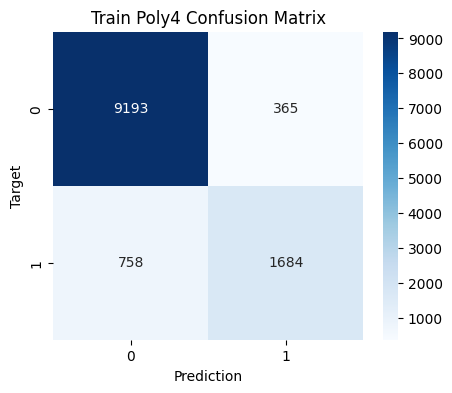

Area under ROC score on Validation Poly4 dataset: 0.9324


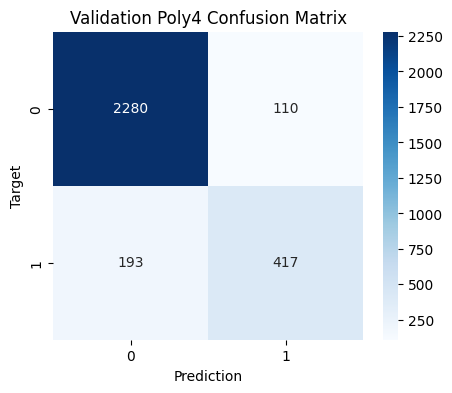

In [3]:
numeric_transformer_poly4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(max_iter=1000))
])

model_pipeline_poly4.fit(train_inputs, train_targets)

train_preds_poly4 = predict_and_plot(
    model_pipeline_poly4,
    train_inputs,
    train_targets,
    name='Train Poly4'
)

val_preds_poly4 = predict_and_plot(
    model_pipeline_poly4,
    val_inputs,
    val_targets,
    name='Validation Poly4'
)


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('/content/regression_data.csv')

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

pipeline_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

pipeline_reg.fit(X_train, y_train)

train_preds = pipeline_reg.predict(X_train)
test_preds = pipeline_reg.predict(X_test)

print("Train R2:", r2_score(y_train, train_preds))
print("Test R2:", r2_score(y_test, test_preds))

train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train R2: 1.0
Test R2: 0.9311212359937131
Train RMSE: 8.389570955674058e-14
Test RMSE: 12.676697837159335


In [ ]:
#Після додавання поліноміальних ознак до 5 степеня модель дуже добре працює на тренувальних даних, але гірше на тестових.
#Це схоже на перенавчання, бо модель стала занадто складною.
#Вона ніби запам’ятовує train дані замість того, щоб вчити загальні закономірності.
#Генералізація вже не така хороша.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [6]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=20, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)

    print(f"\n{name}")
    print("Train R2:", r2_score(y_train, train_preds))
    print("Test R2:", r2_score(y_test, test_preds))



Linear
Train R2: 1.0
Test R2: -0.8327848185651519

Ridge
Train R2: 0.9994300216345037
Test R2: 0.6688019340295243

Lasso
Train R2: 0.9998369781371674
Test R2: 0.9970414997549141

ElasticNet
Train R2: 0.9997248477019357
Test R2: 0.9722945988265759


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e+02, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
#При степені 20 без регуляризації модель сильно перенавчається.
#Після використання Ridge, Lasso і ElasticNet результати на тесті стали стабільнішими.
#Різниця між train і test зменшилась, тобто модель краще узагальнює.
#Найбільш надійно себе показали Ridge та ElasticNet, бо вони стримують занадто великі коефіцієнти.